In [ ]:
import pandas as pd        # 판다스: 표 형태의 데이터를 다루기 위한 대표적인 라이브러리
import numpy as np        # 넘파이: 수학 및 배열 연산을 빠르게 처리하는 라이브러리
import matplotlib.pyplot as plt       # matplotlib: 그래프나 차트를 그릴 때 사용
import seaborn as sns       # seaborn: 그래프를 쉽게 그릴 수 있게 해주는 라이브러리
from sklearn.cross_decomposition import CCA       # CCA를 위한 도구
from sklearn.preprocessing import StandardScaler         # StandardScaler: 데이터를 표준 정규화
from scipy.stats import pearsonr, spearmanr, kendalltau, linregress      # 상관관계 분석 함수
import os


filenames = [
    'Fri(1)_ISCX.csv', 'Fri(2)_ISCX.csv', 'Fri(3)_ISCX.csv',
    'Thu(1)_ISCX.csv', 'Thu(2)_ISCX.csv',
    'Tue_ISCX.csv', 'Wed_ISCX.csv', 'Mon_ISCX.csv'
]

common_ports = None          # 공통 Destination Port 값을 저장할 변수

for file in filenames:               # for반복문 - 파일 이름 리스트를 하나씩 돌면서 반복
    df = pd.read_csv(file)               # 각 파일을 불러와서 데이터프레임df로 저장
    df.columns = df.columns.str.strip()               # column=열 - 열 이름에 공백을 제거    # unique = 중복 제거거
    ports = set(df['Destination Port'].unique())          # 현재 파일에서의 'Destination Port' 열에서 중복되지 않는 포트 번호를 모두 모아 set(=집합)으로 저장
    if common_ports is None:            # 조건문 - 처음 반복이라면, common_ports는 None이므로 현재 ports를 그대로 넣기
        common_ports = ports
    else:                               # 이후부터는 현재 파일의 포트들과 이전까지의 공통 포트들을 비교
        common_ports &= ports           # 둘 다에 있는 포트만 남기기 (교집합: &= )

print(f"8개 파일에서 공통 Destination Port 수: {len(common_ports)}")


8개 파일에서 공통 Destination Port 수: 2178


Pearson correlation: 0.124261618487111, p-value: 0.0
Spearman correlation: -0.3169122563327456, p-value: 0.0
Kendall correlation: -0.23871847109708755, p-value: 0.0


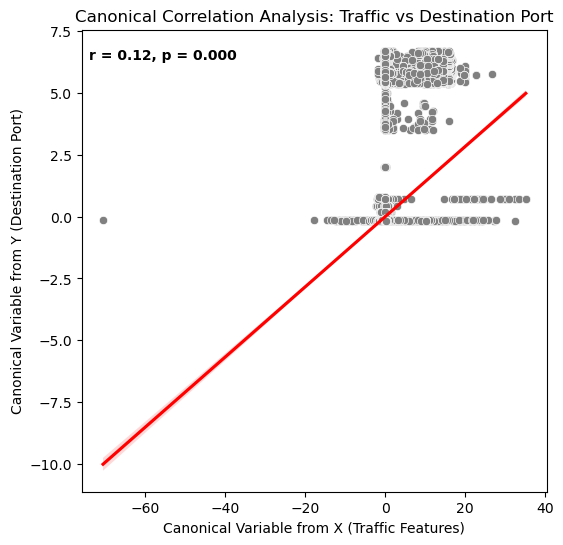

In [ ]:
# <CCA> = 두 그룹의 변수들 간의 관계를 분석
# 여러 파일의 데이터를 합치고 공통 포트만 필터링
# 주요 트래픽 특성과 Destination Port만 선택
# 결측치 제거, 정규화(스케일링)
# CCA를 통해 트래픽 특성과 포트 간의 구조적 관계 분석
# 시각화하고, Pearson/Spearman/Kendall로 보조검증
# 결과를 CSV 파일로 저장


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from scipy import stats
from scipy.stats import linregress
import os

filenames = [
    'Fri(1)_ISCX.csv', 'Fri(2)_ISCX.csv', 'Fri(3)_ISCX.csv',
    'Thu(1)_ISCX.csv', 'Thu(2)_ISCX.csv',
    'Tue_ISCX.csv', 'Wed_ISCX.csv', 'Mon_ISCX.csv'
]

common_ports = None
data_list = []

# 각 파일별 데이터 로드 및 공통 Destination Port 찾기
for file in filenames:
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()  # 공백 제거
    ports = set(df['Destination Port'].unique())
    if common_ports is None:
        common_ports = ports
    else:
        common_ports &= ports  
    data_list.append(df)        #append = 추가

# df들을 모아놓은 data_list에서 데이터들을 모두 합침
filtered_data = pd.concat(data_list)                # concat() = 리스트로 주어진 DataFrame을을 하나로 이어 붙이는 함수
filtered_data = filtered_data[filtered_data['Destination Port'].isin(common_ports)]  
 # isin() = 해당 값이 리스트에 포함되어 있는지 확인

# 변수(columns)를 리스트로 지정 = []
selected_columns = [
    'Flow Duration', 'Total Fwd Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Mean', 'Destination Port'
]
filtered_data = filtered_data[selected_columns].dropna()           # 결측치가 있는 행은 제거

X = filtered_data[['Flow Duration', 'Total Fwd Packets',
                   'Total Length of Fwd Packets', 'Total Length of Bwd Packets',     # 독립 변수(X): 트래픽 특성들들
                   'Fwd Packet Length Mean']]
Y = filtered_data[['Destination Port']]                                              # 종속 변수(Y): Destination Port 하나

# 특성 스케일링 (평균 0, 분산 1)
# StandardScaler() = 정규화
scaler = StandardScaler()              
X_scaled = scaler.fit_transform(X)         

Y_scaled = scaler.fit_transform(Y)

# CCA 수행 
cca = CCA(n_components=1, scale=False)           # (1개의 정준 변수 생성)
cca.fit(X_scaled, Y_scaled)                      # 정규화된 X, Y 데이터로 CCA 학습
X_c, Y_c = cca.transform(X_scaled, Y_scaled)         

# 정준 변수 간 상관계수 및 p-value 계산
corr_coefficient, p_value = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1], linregress(X_c[:, 0], Y_c[:, 0]).pvalue

# 산점도 시각화
plt.figure(figsize=(6, 6))           # 그림 크기 설정
sns.scatterplot(x=X_c[:, 0], y=Y_c[:, 0], color='grey')              # 산점도
sns.regplot(x=X_c[:, 0], y=Y_c[:, 0], scatter=False, color='red')    # 선형 회귀선선
plt.text(min(X_c[:, 0]) * 1.05, max(Y_c[:, 0]) * 0.95,
         f'r = {corr_coefficient:.2f}, p = {p_value:.3f}',           # 상관계수 출력
         horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.xlabel('Canonical Variable from X (Traffic Features)')
plt.ylabel('Canonical Variable from Y (Destination Port)')
plt.title('Canonical Correlation Analysis: Traffic vs Destination Port')

# 결과 저장 경로 생성 및 저장
os.makedirs('./CCA', exist_ok=True)
plt.savefig('./CCA/CCA_Scatter_Traffic_vs_Port.png')

# 정준 변수 간 상관분석 - Pearson, Spearman, Kendall
rho1, p_val1 = stats.pearsonr(X_c[:, 0], Y_c[:, 0])                # Pearson = 선형 관계 (직선 형태로 연관이 있는지)
rho2, p_val2 = stats.spearmanr(X_c[:, 0], Y_c[:, 0])               # Spearman = 순위 기반 관계 (순서가 비슷한지)
rho3, p_val3 = stats.kendalltau(X_c[:, 0], Y_c[:, 0])              # Kendall = 순위 기반 + 민감도 낮은 순위 상관관계

print('Pearson correlation: {}, p-value: {}'.format(rho1, p_val1))
print('Spearman correlation: {}, p-value: {}'.format(rho2, p_val2))
print('Kendall correlation: {}, p-value: {}'.format(rho3, p_val3))

# 상관분석 결과 CSV 저장
correlation = [[round(rho1, 3), round(p_val1, 3),           # 결과를 2차원 리스트로 저장  # round = 반올림
                round(rho2, 3), round(p_val2, 3),
                round(rho3, 3), round(p_val3, 3)]]
df_corr = pd.DataFrame(correlation, columns=[
    'Pearson r', 'Pearson p', 'Spearman r', 'Spearman p', 'Kendall r', 'Kendall p'        # 데이터프레임으로 변환
])
df_corr.to_csv('./CCA/correlation.csv', index=False)



c:\Users\susub\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:48:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    347203
           1       0.90      0.89      0.90    101142

    accuracy                           0.95    448345
   macro avg       0.94      0.93      0.93    448345
weighted avg       0.95      0.95      0.95    448345



100%|===================| 448287/448345 [35:47<00:00]        

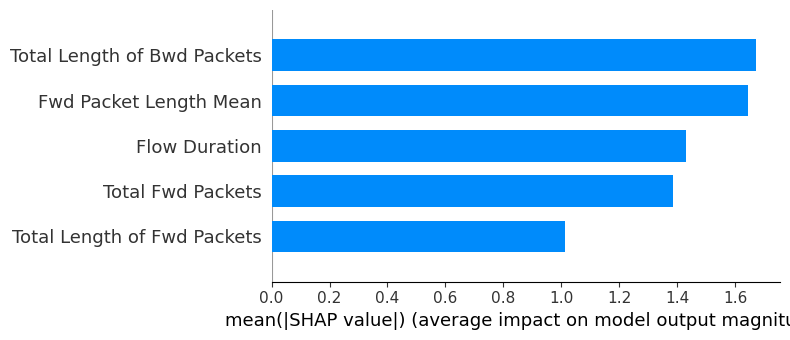

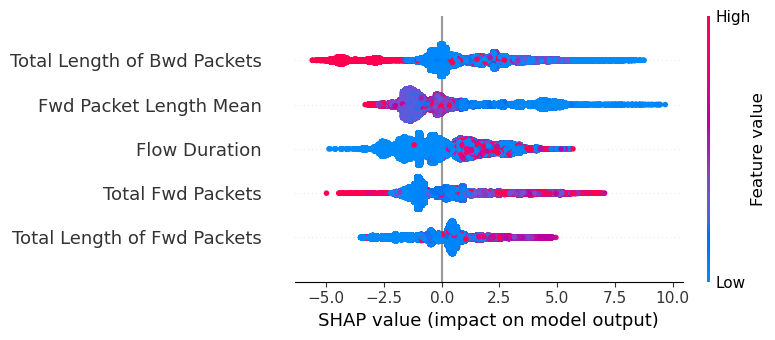

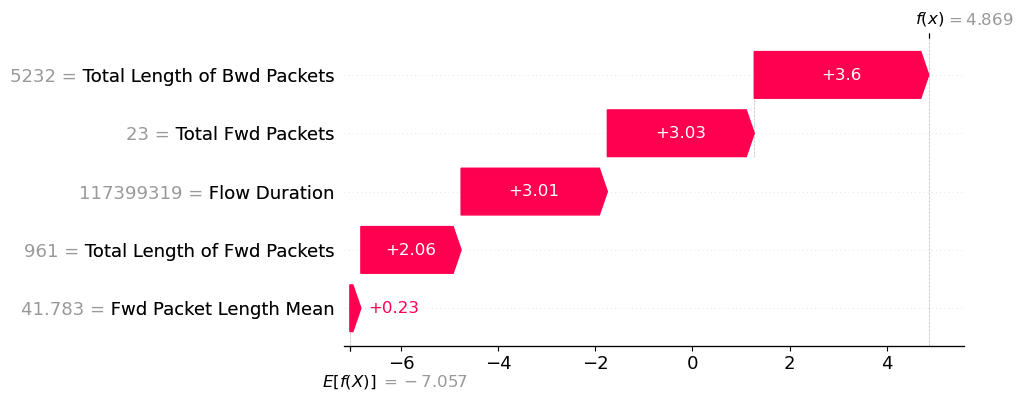

c:\Users\susub\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\susub\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\susub\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt


filenames = [
    'Fri(1)_ISCX.csv', 'Fri(2)_ISCX.csv', 'Fri(3)_ISCX.csv',
    'Thu(1)_ISCX.csv', 'Thu(2)_ISCX.csv',
    'Tue_ISCX.csv', 'Wed_ISCX.csv', 'Mon_ISCX.csv'
]

# 각 파일에서 공통 Destination Port 추출 및 데이터 합치기
common_ports = None
data_list = []

for file in filenames:
    df_temp = pd.read_csv(file)
    df_temp.columns = df_temp.columns.str.strip()  # 공백 제거
    ports = set(df_temp['Destination Port'].unique())
    if common_ports is None:
        common_ports = ports
    else:
        common_ports &= ports  
    data_list.append(df_temp)

# 데이터 합치고 공통 포트만 필터링
df = pd.concat(data_list)
df = df[df['Destination Port'].isin(common_ports)]


features = [
    'Flow Duration', 'Total Fwd Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Mean'
]
selected_columns = features + ['Destination Port']
df = df[selected_columns].dropna()

# 목적변수 생성                                                # True -> 1, False -> 0 으로 이진 분류
df['load'] = (df['Destination Port'] == 443).astype(int)      # Destination Port가 443이면 부하 High(1), 아니면 Low(0)

X = df[features]          # X: 입력 변수 (5가지 트래픽 특성)
y = df['load']            # y: 출력 변수 (load = 부하 상태)

# 학습/테스트 데이터 분할 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42      # test_size=0.2: 데이터의 20%는 테스트용 / stratify=y: 클래스 비율을 유지하기 위한 옵션
)

# <XGBoost> = 머신러닝 알고리즘, 예측하는 모델
# XGBoost 모델 학습
model = XGBClassifier(
    random_state=42,
    n_estimators=100,         # 트리 100개
    use_label_encoder=False,
    eval_metric='logloss'         # eval_metric='logloss' = 로지스틱 손실 함수 사용
)
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)      # predict() = 예측
print("Classification Report:")
print(classification_report(y_test, y_pred))         # Precision(=정밀도), Recall(=재현율), F1-score(=균형지표)등을 출력

# <SHAP> = 머신러닝 모델의 예측 결과를 해석
# SHAP 해석
explainer = shap.Explainer(model, X_train)       # 학습 데이터 기반 설명기 생성 
shap_values = explainer(X_test)                  # 테스트 데이터에 대해 SHAP 값 계산

# SHAP summary plots
shap.summary_plot(shap_values, X_test, plot_type='bar')         # 막대그래프 -> 즁요도도
shap.summary_plot(shap_values, X_test)                          # 기본 piot -> 개별 특성별 영향력 분포

# 개별 샘플 워터폴 플롯 (0번째 샘플)
shap.plots.waterfall(shap_values[0])                  # terfall = 어떤 특성이 예측값에 얼마나 영향을 미쳤는지를 단계적으로 나타냄냄

# <LIME> = 머신러닝 모델의 예측 결과를 해석 - 개별 예측을 국소적으로 설명)
# LIME 해석
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,          # numpy 형태
    feature_names=features,            
    class_names=['Low', 'High'],           # 클래스 이름
    mode='classification'                  # 분류
)

# LIME로 첫 번째 샘플 해석
i = 0              # 첫번재 테스트 샘플플
exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=model.predict_proba,         # 예측 확률 반환 함수 
    num_features=5,
    num_samples=300          # LIME이 내부적으로 샘플링할 개수 일단 300개만
)

# Jupyter 노트북 환경에서 시각화
exp.show_in_notebook()



In [ ]:
# <TableOne> = 그룹별 통계 요약

import pandas as pd
from tableone import TableOne
import os

# 사용하려는 주요 특징들
features = [
    'Flow Duration', 'Total Fwd Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
    'Fwd Packet Length Mean'
]
target = 'Destination Port'
columns = features + ['load']
categorical = ['load']
groupby = 'load'                    # 그룹 기준은 load (Low vs High)

# 요일별 CSV 파일 경로들
filenames = [
    'Mon_ISCX.csv', 'Tue_ISCX.csv', 'Wed_ISCX.csv',
    'Thu(1)_ISCX.csv', 'Thu(2)_ISCX.csv',
    'Fri(1)_ISCX.csv', 'Fri(2)_ISCX.csv', 'Fri(3)_ISCX.csv'
]

# 공통 Destination Port 찾기 및 데이터프레임 리스트
common_ports = None
df_list = []

for file in filenames:
    df = pd.read_csv(file)
    df.columns = df.columns.str.strip()
    
    df['Destination Port'] = df['Destination Port'].astype(int)     # 포트 번호는 정수형으로 변환 astype(int)
    
    
    ports = set(df['Destination Port'].unique())
    if common_ports is None:
        common_ports = ports
    else:
        common_ports &= ports
    
   
    df = df[features + [target]].dropna()
    df_list.append(df)

# 모든 데이터 합치기
df_all = pd.concat(df_list, ignore_index=True)

# 공공통 Destination Port 기준 필터링
df_all = df_all[df_all['Destination Port'].isin(common_ports)]

# load 변수 생성 
df_all['load'] = (df_all['Destination Port'] == 443).astype(int)    # 443이면 High(1) // Low(0))

# TableOne 생성 
table1 = TableOne(data=df_all[columns], 
                  categorical=categorical,     # 범주형 변수
                  groupby=groupby,             # 그룹 기준 (load)
                  pval=True)                   # p-value 포함

# 결과 저장
os.makedirs('./TableOne_Summary', exist_ok=True)
with open('./TableOne_Summary/AllDays_tableone_summary.txt', 'w', encoding='utf-8') as f:
    f.write(str(table1))

# 7. 출력
print(table1)

c:\Users\susub\anaconda3\Lib\site-packages\tableone\tableone.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self._categorical] = handle_categorical_nulls(data[self._categorical], self._categorical)


                                         Grouped by load                                                                                   
                                                 Missing                  Overall                        0                        1 P-Value
n                                                                         2241722                  1736012                   505710        
Flow Duration, mean (SD)                               0  18194508.8 (36565761.1)  15169852.3 (33733479.9)  28577613.5 (43374456.7)  <0.001
Total Fwd Packets, mean (SD)                           0             11.3 (842.3)              9.6 (954.5)             17.2 (132.0)  <0.001
Total Length of Fwd Packets, mean (SD)                 0           545.9 (6132.8)           304.2 (5532.5)          1375.8 (7794.9)  <0.001
Total Length of Bwd Packets, mean (SD)                 0      20370.6 (2543013.8)      19531.8 (2882614.9)       23250.0 (376521.3)   0.099
Fwd Packet Length Me